In [3]:
#Nye imports
import os
import pathlib
import gradio as gr
import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


Definerer mappestruktur og legger alle dataen i en tabell

In [2]:
input_dir = './Jellyfish'
categories = ['barrel_jellyfish','blue_jellyfish','compass_jellyfish','lions_mane_jellyfish','mauve_stinger_jellyfish','moon_jellyfish']

data = []
labels = []
for category_idx, category in enumerate(categories):
    for file in os.listdir(os.path.join(input_dir, category)):
        img_path = os.path.join(input_dir, category, file)
        img = imread(img_path)
        img = resize(img, (15, 15))
        data.append(img.flatten())
        labels.append(category_idx)

data = np.asarray(data)
labels = np.asarray(labels)


IndexError: list index out of range

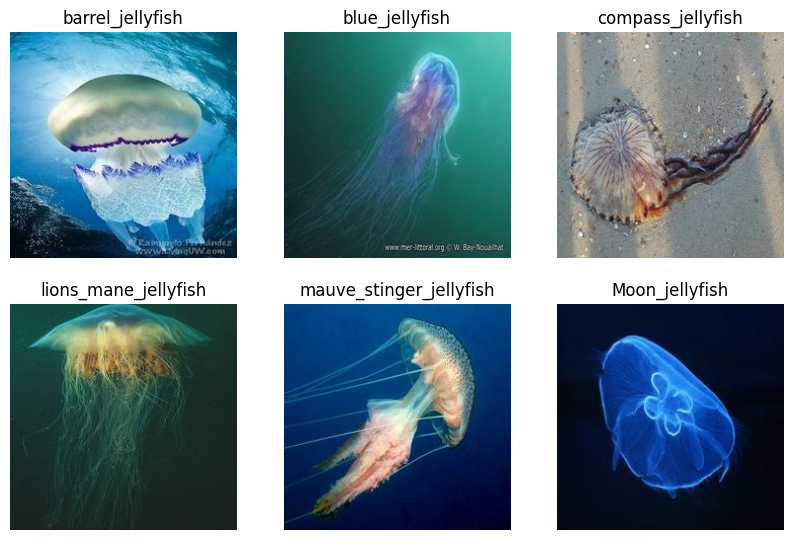

In [4]:
#Visualisere dataen

dataset_directory = r"./Jellyfish"

data_dir = pathlib.Path(dataset_directory)

image_count = 1

plt.figure(figsize=(10, 10))
for folders in data_dir.glob('*/'):

    image_files = list(folders.glob('*.jpg'))
    image_path = image_files[0]
    img = Image.open(image_path)
    ax = plt.subplot(3, 3, image_count)
    plt.imshow(img)
    plt.title(folders.name)
    plt.axis("off")
        
    image_count += 1  # Move to the next subplot


**Dele opp i trenings og valideringsdata**


In [19]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

#TODO **Trene en modell**

GRADIO NETTSIDE 

In [140]:

from click import launch

def greet(name, intensity):
    return "Hello, " + name + "!" * int(intensity)

demo = gr.Interface(
    fn=greet,
    inputs=["image", "slider"],
    outputs=["text"],
    
)

demo.launch()


* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
